# Automatic Pairwise Causal Discovery

### Conditional Distribution Similarity Score

Goals: 
- evaluate pairwise methods from causal discovery toolbox. Particularly `CDS`: conditional distribution similarity
- analize *life expectancy* in relation to *Gross National Income per capita*

Data Sources:
-  Information for pair0074: http://webdav.tuebingen.mpg.de/cause-effect/pair0074.txt, based on [UNdata](http://data.un.org)
  
Libraries
- causal inference: `cdt`
- visualization: `matplotlib` and `seaborn`
- other libraries: `pandas`, `numpy`

### Step 1: Load and explore data
#### 1.1.- Load data from `http://webdav.tuebingen.mpg.de/cause-effect`

In [1]:
import pandas as pd
df_xy = pd.read_csv('http://webdav.tuebingen.mpg.de/cause-effect/pair0074.txt', sep=' ', names=['x','y'], index_col=False)
df_xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 2 columns):
x    194 non-null int64
y    194 non-null int64
dtypes: int64(2)
memory usage: 3.2 KB


#### 1.2.- Visualization

Histograms in diagonal. Scatterplot off diagonal

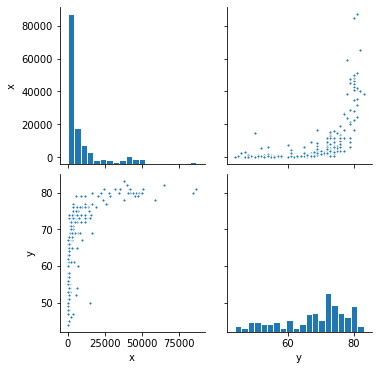

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.PairGrid(df_xy, vars=["x", "y"])
g = g.map_diag(plt.hist, edgecolor="w", bins=20)
g = g.map_offdiag(plt.scatter, edgecolor="w", s=10)

### Step 2: Pairwise causal discovery

#### 2.1.- Plot directed graph
Use `CDS` default implementation (and parameters) from `cdt.causality.pairwise`

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


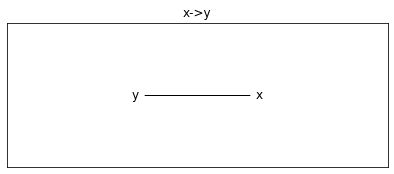

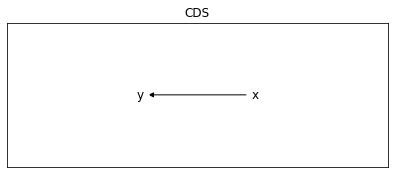

In [3]:
from cdt.causality.pairwise import *
import networkx as nx

ugraph = nx.Graph()
ugraph.add_edges_from([('x','y')])


def format_graph_plot(graph,mycount, title):
    pos = nx.drawing.layout.circular_layout(graph)
    plt.figure(0,figsize=(15,9))
    plt.subplot(3,2,mycount)
    nx.draw_networkx(graph,pos, node_color='#ffffff')

    plt.title(title)
    plt.margins(1,0.5)
    plt.show()

format_graph_plot(ugraph, 1, 'x->y')
    

def orient_graph_with_model(data, ugraph, mymodel):
    model = mymodel()
    graph = model.orient_graph(data, nx.DiGraph(ugraph))
    sorted_graph = nx.DiGraph()
    sorted_graph.add_edges_from(sorted(graph.edges()))
    return sorted_graph

graph = orient_graph_with_model(df_xy, ugraph, CDS)
format_graph_plot(graph, 2, 'CDS')

def test_pairwise_model(data, mymodel,mycount):
    obj = mymodel()
    graph = obj.orient_graph(data, nx.DiGraph(ugraph))
    sorted_graph = nx.DiGraph()
    sorted_graph.add_edges_from(sorted(graph.edges()))
    pos = nx.drawing.layout.circular_layout(sorted_graph)   
    #
    plt.subplot(3,2,mycount)
    nx.draw_networkx(sorted_graph,pos,node_color='#ffffff')
    plt.title(mymodel.__name__)
    plt.margins(1,0.5)


#### 2.2.- Analyze `CDS` method

The `CDS` (*Conditional Distribution Similarity Statistic*)  measures the std. of the rescaled values of y (resp. x) after binning in the x (resp. y) direction. The lower the std. the more likely the pair to be x->y (resp. y->x). It is a single feature of the Jarfo model. See https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/causality.html#cds. 

This metric is based on the paper [Conditional distribution variability measures for causality
detection](https://arxiv.org/pdf/1601.06680.pdf), by J.A.R. Fonollosa, 2016

In [4]:
def test_pairwise_cds_score(X, Y, model):
    x = df_xy[X]
    y = df_xy[Y]
    mybool = model.cds_score(x,y)<model.cds_score(y,x)
    return mybool

COL_X = 'x'
COL_Y = 'y'

myresult = test_pairwise_cds_score(COL_X, COL_Y, CDS())
print("'{}' -> '{}' seems {} according to cds_score (with default parameters)".format(COL_X, COL_Y, myresult))

myresult2 = test_pairwise_cds_score(COL_X, COL_Y, CDS(maxdev=2))
print("'{}' -> '{}' seems {} according to cds_score (with `maxdev=2`)".format(COL_X, COL_Y, myresult2))

'x' -> 'y' seems True according to cds_score (with default parameters)
'x' -> 'y' seems False according to cds_score (with `maxdev=2`)


`x` -> `y` as True is what showed previously the `orient_graph` method. This is consistent with behavior with default parameters. But according to my first (quick&dirty) experiments it seems results depend much on the discretization or binning phase. And this discretization phase depends on 3 parameters: `ffactor`, `maxdev` and `minc`. 

As the [author explains]([https://github.com/jarfo/cause-effect/issues/1#issuecomment-724697472]):
 "*ffactor and maxdev controls the discretization (quantization) 
process (ffactor controls the resolution and maxdev the outliers).
minc is a threshold on the minimum number of samples for a given x discrete value or label. A x value that appears less than minc times is ignored*"

Default values are `ffactor`=2, `maxdev`=3, `minc`=12

First of all, let's understand the implications of default values for our variables

#### 2.2.1.- Influence of CDS parameters in discretization errors

`discretized_values()` and `discretized_sequence()` methods in the next analysis are based on `CDS` implementation by [`CausalDiscoveryToolbox`](https://github.com/FenTechSolutions/CausalDiscoveryToolbox/blob/master/cdt/causality/pairwise/CDS.py#L69). Which in turn is based on original `conditional_distribution_similarity` feature on *jarfo* model: https://github.com/jarfo/cause-effect/blob/master/features.py#L89

In [5]:
FFACTOR = 2
MAXDEV = 3

def discretized_values(x, ffactor, maxdev):
    if len(set(x)) > (2*ffactor*maxdev+1):
        vmax =  ffactor*maxdev
        vmin = -ffactor*maxdev
        return range(vmin, vmax+1)
    else:
        return sorted(list(set(x)))

x = df_xy[COL_X]
myrange = discretized_values(x, FFACTOR, MAXDEV)
print("x: {} different ({}) values are discretized in {} bins, on {}".format(len(set(x)),x.dtype,len(myrange),myrange))

y = df_xy[COL_Y]
myrange = discretized_values(y, FFACTOR, MAXDEV)
print("y: {} different ({}) values are discretized in {} bins, on {}".format(len(set(y)),y.dtype,len(myrange),myrange))


x: 178 different (int64) values are discretized in 13 bins, on range(-6, 7)
y: 39 different (int64) values are discretized in 13 bins, on range(-6, 7)


Average SMAPE error between discrete filtered sequences and scaled originals is 16.4%



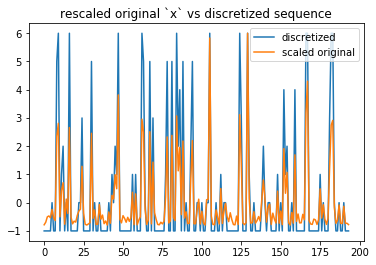

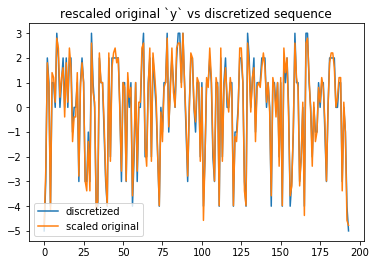

In [6]:
import numpy as np
from collections import Counter

def discretized_sequence(x, ffactor=2, maxdev=3, norm=True):
    if len(set(x)) > len(range(-ffactor*maxdev,ffactor*maxdev+1)):
        
        x = (x - np.mean(x))/np.std(x)
        xf = x[abs(x) < maxdev]
        x = (x - np.mean(xf))/np.std(xf)
        x = np.round(x*ffactor)
        vmax =  ffactor*maxdev
        vmin = -ffactor*maxdev
        x[x > vmax] = vmax
        x[x < vmin] = vmin
    return x

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 0.5*np.mean(abs(y_true-y_pred)/(abs(y_true)+abs(y_pred)))

def discretized_sequence_minc(xd,minc=12):
    xdf= xd.where(~xd.isin([x for x, count in Counter(xd).items() if count < minc]))
    ratio_nulls = len(xdf[xdf.isnull()])/len(xdf)
    
    # To ignore effect of MINC filtering unless discarded values exceed 50% of samples
    if ratio_nulls > 0.5:
        raise ValueError('Too much filtered values ({:.4}%) because count <  MINC={}'.format(100*ratio_nulls, minc))
    
    xdf[np.isnan(xdf)]=max(xd)
    return xdf

def rescaled_sequence(x, amplitude=1):
    xs =amplitude*(x - np.mean(x))/(max(x) -np.mean(x))
    return xs

def explore_discretization_errors(col, ffactor=2, maxdev=3, minc=12, plot=True):
    x = df_xy[col]
  
    xd = discretized_sequence(x, ffactor=ffactor, maxdev=maxdev)
    xs =rescaled_sequence(x,max(xd))
    xdf= discretized_sequence_minc(xd,minc=minc)
    smape = symmetric_mean_absolute_percentage_error(xs,xdf)
    
    if plot:
        plt.figure()
        plt.plot(xd, label="discretized")
        plt.plot(xs, label="scaled original")
        plt.legend()
        plt.title('rescaled original `{}` vs discretized sequence'.format(col))
    
    return smape

avg_error = (explore_discretization_errors(COL_X) + explore_discretization_errors(COL_Y))/2
DISCRETIZATION_ERROR_MESSAGE="Average SMAPE error between discrete filtered sequences and scaled originals is"
print("{} {:.1F}%\n".format(DISCRETIZATION_ERROR_MESSAGE,100*avg_error))

Considering also that, with default parameters, effect on `MINC`=12 removes more than 16% of values of y. Let's see what happens if we set `minc=1` and tune `ffactor` and `maxdev` we can get discretization distorsion (*Symmetric Mean Average Percentage Error*) below 10%:

In [7]:
def print_discretization_errors(COL_X,COL_Y,p):
    error_x = explore_discretization_errors(COL_X, ffactor=p["ffactor"],maxdev=p["maxdev"],minc=p["minc"], plot=False)
    error_y = explore_discretization_errors(COL_Y, ffactor=p["ffactor"],maxdev=p["maxdev"],minc=p["minc"], plot=False)
    print("\t{:.1F}%: {}".format(50*(error_x+error_y),p))

print("{}: ".format(DISCRETIZATION_ERROR_MESSAGE))
print_discretization_errors(COL_X,COL_Y,{"ffactor":2,"maxdev":3,"minc":1})
print_discretization_errors(COL_X,COL_Y,{"ffactor":6,"maxdev":3,"minc":1})

Average SMAPE error between discrete filtered sequences and scaled originals is: 
	15.0%: {'ffactor': 2, 'maxdev': 3, 'minc': 1}
	9.5%: {'ffactor': 6, 'maxdev': 3, 'minc': 1}


By generating a meshgrid, with `ffactor` and `maxdev` from 1 to 10, it is possible to visualize the discretization error surface:

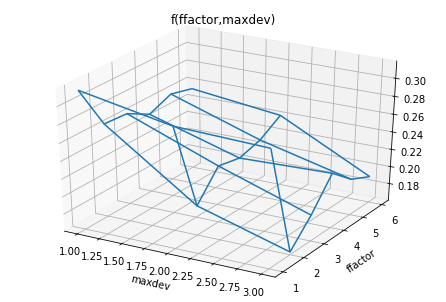

In [8]:
def test_discretization_error_grid_params(X, Y, f_range, d_range, minc=12):
    errors = np.empty((len(f_range),len(d_range)))
    for f in f_range:
        for d in d_range:
            mape_x = explore_discretization_errors(X, ffactor=f, maxdev=d, minc=minc, plot=False)
            mape_y = explore_discretization_errors(Y, ffactor=f, maxdev=d, minc=minc, plot=False)
            
            errors[np.where(f_range==f)[0][0]][np.where(d_range==d)[0][0]] = (mape_x + mape_y)/2
    return errors

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_meshgrid(f_range,d_range,nu,title='f(ffactor,maxdev)', rotate=False,interactive=False):
    F,D = np.meshgrid(d_range,f_range)
    
    if interactive:
        %matplotlib notebook
    else:
        %matplotlib inline

    fig = plt.figure()      
    ax = Axes3D(fig)
    
    if rotate:
        # Rotate default angle for better visualization
        ax.view_init(-140, 30)
    
    # Surface, wireframe and scatter3D are alternative view. It seems wireframe is more clear for this purpose
    #ax.plot_surface(F, D, nu)
    ax.plot_wireframe(F, D, nu)
    #ax.scatter3D(F,D, nu)
    
    plt.xlabel('maxdev')
    plt.ylabel('ffactor')
    plt.title(title)
   
    return

# default ffactor was 3. I make a grid from 1 to 6
F_RANGE = np.arange(1, 7, 1)

# default maxdev was 2. I make a grid from 1 to 4. Higher values get too much discards because MINC<12
D_RANGE = np.arange(1, 4, 1)    

error = test_discretization_error_grid_params(COL_X, COL_Y, F_RANGE, D_RANGE, minc=12)

plot_meshgrid(F_RANGE,D_RANGE,error,interactive=False)

For `minc=12` error discretization has a local minima on default values `ffactor`=2 and `maxdev`=3. That is good. However, we are constrained because higher resolution values generate too much discarded samples (>50%). So if we compare with `minc=1` and higher ranges for `ffactor` and `maxdev`:

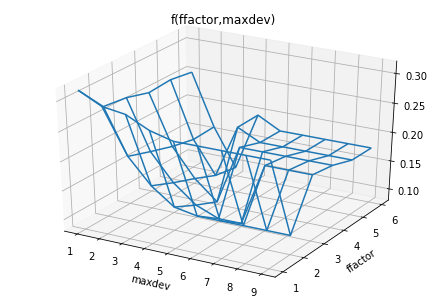

In [9]:
# default ffactor was 3. I make a grid from 1 to 6
F_RANGE = np.arange(1, 7, 1)

# default maxdev was 2. I make a grid from 1 to 9
D_RANGE = np.arange(1, 10, 1)  
error = test_discretization_error_grid_params(COL_X, COL_Y, F_RANGE, D_RANGE, minc=1)
plot_meshgrid(F_RANGE,D_RANGE,error, interactive=False)

Besides local minimum on `ffactor=2`, `maxdev=3` we now find lower minimums on `ffactor=3` and `maxdev in (5,6)` and also `ffactor=4` and `maxdev=4`. We get errors below 9%, lower than 16.4% for default values. Also lower than 15% resulting to set `minc=1` and keep `ffactor=2` and `maxdev=3`:

In [10]:
print("{}: ".format(DISCRETIZATION_ERROR_MESSAGE))
print_discretization_errors(COL_X,COL_Y,{"ffactor":4,"maxdev":4,"minc":1})
print_discretization_errors(COL_X,COL_Y,{"ffactor":3,"maxdev":6,"minc":1})
print_discretization_errors(COL_X,COL_Y,{"ffactor":3,"maxdev":5,"minc":1})
print_discretization_errors(COL_X,COL_Y,{"ffactor":2,"maxdev":3,"minc":1})

Average SMAPE error between discrete filtered sequences and scaled originals is: 
	8.5%: {'ffactor': 4, 'maxdev': 4, 'minc': 1}
	8.5%: {'ffactor': 3, 'maxdev': 6, 'minc': 1}
	8.5%: {'ffactor': 3, 'maxdev': 5, 'minc': 1}
	15.0%: {'ffactor': 2, 'maxdev': 3, 'minc': 1}


#### 3.3.2.- Sensitivity of `cds_score` and orientation estimations to `CDS` parameters

'x'->'y' seems True 34/54=63% times according to cds_score


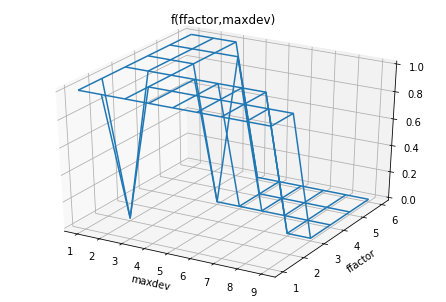

In [11]:
def test_pairwise_cds_score_grid_params(X, Y, f_range, d_range, minc=12):
    result = []
   
    mysize = (len(f_range),len(d_range))
    
    aresult = np.empty(mysize)
    for f in f_range:
        for d in d_range:
            x = df_xy[X]
            y = df_xy[Y]
            obj = CDS(ffactor=f, maxdev=d,minc=minc)
            mybool = obj.cds_score(x,y)<obj.cds_score(y,x)
            result.append(mybool)
            aresult[np.where(f_range==f)[0][0]][np.where(d_range==d)[0][0]] = mybool
    myres = 100*np.mean(result)
    print("'{}'->'{}' seems True {}/{}={:.0f}% times according to cds_score".format(X,Y,np.sum(result),len(result),myres))
   
    return aresult


cds_score = test_pairwise_cds_score_grid_params(COL_X, COL_Y, F_RANGE, D_RANGE, minc=12)

plot_meshgrid(F_RANGE,D_RANGE,cds_score, interactive=False)


'x'->'y' seems True 39/54=72% times according to cds_score


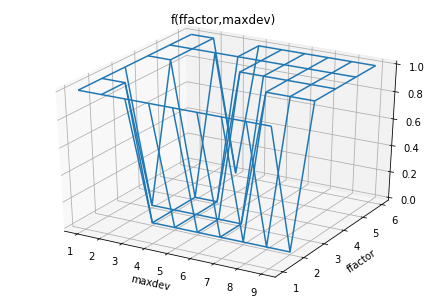

In [12]:
cds_score = test_pairwise_cds_score_grid_params(COL_X, COL_Y, F_RANGE, D_RANGE, minc=1)
plot_meshgrid(F_RANGE,D_RANGE,cds_score)